# Word Pronunciations: Word to Phoneme Conversion

A phoneme is a sound or a group of different sounds perceived to have the same function by speakers of the language or dialect in question. An example is the English phoneme /k/, which occurs in words such as cat, kit, scat, skit.

<div class='alert alert-info'><strong>Phoneme Conversion:</strong> Converts lexical orthographic symbols (words) to phonetic representation along with other possible information such as stress placement.</div>


__Phoneme Conversion__
- Words to phonemes converters can help you figure out how to pronounce a certain word. e.g. Google word pronunication utility
- Conversion of words to phonemes is an important step in the process of Text-to-Speech synthesis, where a system is given an input text which is preprocessed through various stages to identify how a text sentence needs to be spoken out loud by identifying the pronunciations and prosody of each word present in the sentence.


In [ ]:
import pandas as pd
import numpy as np

# Model Related Libraries
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

# Viz Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries used for Audio Data
import librosa
import librosa.display

# Viz Params
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')

In [ ]:
!pip install datasets -q
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.1 MB/s eta 0:00:00


Dataset is on Kaggle so using the API to get the data.

In [ ]:
# Install the kaggle library
!pip install -q kaggle

# Upload the Kaggle API keys
from google.colab import files
files.upload()

!mkdir ~/.kaggle

# Copy the json file to the folder
!cp kaggle.json ~/.kaggle

# Change permissions for keys to work with the Kaggle API
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d rtatman/cmu-pronouncing-dictionary

# Unzipping the dataset
! unzip /content/cmu-pronouncing-dictionary.zip

Saving kaggle.json to kaggle.json
100% 904k/904k [00:00<00:00, 977kB/s]
100% 904k/904k [00:00<00:00, 977kB/s]
Archive:  /content/cmu-pronouncing-dictionary.zip
  inflating: LICENSE.txt             
  inflating: cmudict.dict            
  inflating: cmudict.phones          
  inflating: cmudict.symbols         
  inflating: cmudict.vp              


# Word To Phoneme

In [ ]:
words = []
phonics_list = []
dict_file = open('/content/cmudict.dict', 'r')
with dict_file as f:
    phonics = [line.rstrip('\n') for line in f]
    for p in phonics:
        x = p.split(' ')
        words.append(x[0])
        phonics_list.append(' '.join(x[1:]))
data = pd.DataFrame({'Word': words, 'Phonics': phonics_list})
data.head()

,Word,Phonics
0,'bout,B AW1 T
1,'cause,K AH0 Z
2,'course,K AO1 R S
3,'cuse,K Y UW1 Z
4,'em,AH0 M


In [ ]:
df = data.sample(100000).reset_index(drop=True)
df

,Word,Phonics
0,immense,IH2 M EH1 N S
1,viglione,V IH0 G L IY0 OW1 N IY2
2,kibbutzniks,K IH0 B UH1 T S N IH0 K S
3,nationalist,N AE1 SH AH0 N AH0 L AH0 S T
4,apparatuses,AE2 P ER0 AE1 T AH0 S AH0 Z
...,...,...
99995,scallions,S K AE1 L Y AH0 N Z
99996,finnick,F IH1 N IH0 K
99997,hasidic(2),HH AH0 S IY1 D IH0 K
99998,peres's,P EH1 R EH0 Z IH0 Z


In [ ]:
df[~df['Word'].apply(lambda x: x.isalnum())]

,Word,Phonics
9,blanket(2),B L AE1 NG K IH0 T
13,frankfort's,F R AE1 NG K F ER0 T S
15,associate's,AH0 S OW1 S IY0 AH0 T S
31,exiles(2),EH1 K S AY2 L Z
35,urges(2),ER1 JH IH0 Z
...,...,...
99980,sql(2),S IY1 K W UH0 L
99984,reso's(2),R IY1 Z OW0 Z
99990,criminals',K R IH1 M AH0 N AH0 L Z
99997,hasidic(2),HH AH0 S IY1 D IH0 K


### By adding 'startseq' at the beginning and 'endseq' at the end of each phoneme sequence, it marks the beginning and end of the sequence.

In [ ]:
df['Phonics'] = 'startseq '+df['Phonics']+' endseq'
df

,Word,Phonics
0,immense,startseq IH2 M EH1 N S endseq
1,viglione,startseq V IH0 G L IY0 OW1 N IY2 endseq
2,kibbutzniks,startseq K IH0 B UH1 T S N IH0 K S endseq
3,nationalist,startseq N AE1 SH AH0 N AH0 L AH0 S T endseq
4,apparatuses,startseq AE2 P ER0 AE1 T AH0 S AH0 Z endseq
...,...,...
99995,scallions,startseq S K AE1 L Y AH0 N Z endseq
99996,finnick,startseq F IH1 N IH0 K endseq
99997,hasidic(2),startseq HH AH0 S IY1 D IH0 K endseq
99998,peres's,startseq P EH1 R EH0 Z IH0 Z endseq


In [ ]:
max_len_ip = df['Word'].apply(lambda x: len(x)).max()
max_len_op = df['Phonics'].apply(lambda x: len(x.split())).max()

In [ ]:
words = df['Word'].tolist()
phonemes = df['Phonics'].tolist()

## Tokenization

<div class='alert alert-info'><strong>Tokenization: </strong>Tokenization is nothing but splitting the raw text into small chunks of words or sentences, called tokens. In case of tokenization of words, it simply means to split them into characters.</div>


The words and phonics need to be converted into some encodings which can be passed to the LSTM encoder-decoder architecture while training, therefore we need to perform tokenization on both the input as well as the output
- Character level tokenization of input words
- Word level tokenization of output sequences

An example of different types of tokenization is given below

<img src='https://miro.medium.com/max/1400/1*RcSo3UpBTorMI6YJvVizSg.jpeg'>

In [ ]:
char_tokenizer = Tokenizer(char_level=True,oov_token='OOV')
char_tokenizer.fit_on_texts(words)
char_vocab_size = len(char_tokenizer.word_index) + 1
print("Character Vocab Size: ",char_vocab_size)

phone_tokenizer = Tokenizer(oov_token='OOV')
phone_tokenizer.fit_on_texts(phonemes)
phone_vocab_size = len(phone_tokenizer.word_index) + 1
print("Phoneme Vocab Size: ",phone_vocab_size)

Character Vocab Size:  37
Phoneme Vocab Size:  78


In [ ]:
ch_sequences = char_tokenizer.texts_to_sequences(words)
ph_sequences = phone_tokenizer.texts_to_sequences(phonemes)

## Phoneme Sequence Generation Preprocessing
- The output phonetic sequence needs to be preprocessed in a way such that everytime the decoder is fed the encoded information (encoder output) of the sequence of characters passed to it along with the startseq tag (to indicate the beginning of the phoneme sequence) it should be able to predict the next phoneme in the sequence.
- An example is given in the table below

| Sentence | Tokenized Sequence |
| --- | --- |
| startseq | [2] |
| startseq M | [2, 13] |
| startseq M AH0 | [2, 13, 4] |
| startseq M AH0 G | [2, 13, 4, 24] |
| startseq M AH0 G IH1 | [2, 13, 4, 24, 22] |
| startseq M AH0 G IH1 L | [2, 13, 4, 24, 22, 7] |
| startseq M AH0 G IH1 L endseq | [2, 13, 4, 24, 22, 7, 3] |

- The input and output vector encoded representations are padded with zeros to match the longest sequence present in the input and output respectively. Instead of choosing the longest possible record present in the data one can choose another length of padding/shortening using some statistical technique or through EDA as well.

In [ ]:
print("Phoneme: ", phonemes[2])
print("Phonic Sequence: ",ph_sequences[2])

Phoneme:  startseq K IH0 B UH1 T S N IH0 K S endseq
Phonic Sequence:  [2, 10, 12, 17, 57, 8, 6, 5, 12, 10, 6, 3]



__Encoder-Decoder Architecture__
- This type of architecture can be used for solving Sequence to Sequence problems aka Seq2Seq
- Seq2Seq encoder decoder architectures can be constructed using the Recurrent Neural Networks (RNNs) (Transformers being a more popular choice these days)
- LSTM, which is a variant of RNN, will be used in this kernel
- This architecture is comprised of two models: one for reading the input sequence and encoding it into a fixed-length vector, and a second for decoding the fixed-length vector and outputting the predicted sequence.
- We can formulate the problem of word to phoneme conversion in the same way, where the words are tokenized at a character level and passed as an input sequence of fixed length to the encoder, and the decoder is supposed to predict the output sequence of phonemes.
- This kind of architecture is/was (Transformers have overtaken) typically used in language translation models, where a sentence in one language is passed as an input sequence to the decoder and the encoder predicts the output sequence in the target language.

<img src='https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg'>

In [ ]:
encoder_inputs = pad_sequences(ch_sequences, maxlen=max_len_ip, padding='post')

decoder_inputs = []
decoder_outputs = []

for ph in ph_sequences:
    decoder_inputs.append(ph[:-1])
    decoder_outputs.append(ph[1:])

decoder_inputs = pad_sequences(decoder_inputs, maxlen=max_len_op, padding='post')
decoder_outputs = pad_sequences(decoder_outputs, maxlen=max_len_op, padding='post')

In [ ]:
n = len(words)
split_index = int(0.85 * n)

X_train = [encoder_inputs[:split_index], decoder_inputs[:split_index]]
y_train = decoder_outputs[:split_index]

X_test = words[split_index:]
y_test = phonemes[split_index:]

In [ ]:
ch_vocab = 37
ph_vocab = 77

# Encoder
char_input = Input(shape=(None,))
x = Embedding(ch_vocab, 256, mask_zero=True, name = "EncEmbedding")(char_input)
output_y, state_h, state_c = LSTM(256, return_state=True, name = "EncLSTM")(x)

# Decoder
ph_input = Input(shape=(None,))
embedding_layer = Embedding(ph_vocab, 256, mask_zero=True, name = "DecEmbedding")
x = embedding_layer(ph_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name = "DecLSTM")
output_y, _ , _ = decoder_lstm(x, initial_state=[state_h, state_c])
softmax_dense = Dense(ph_vocab, activation='softmax')
output = softmax_dense(output_y)

model = Model(inputs=[char_input, ph_input],outputs=output)
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 EncEmbedding (Embedding)    (None, None, 256)            9472      ['input_1[0][0]']             
                                                                                                  
 DecEmbedding (Embedding)    (None, None, 256)            19712     ['input_2[0][0]']             
                                                                                              

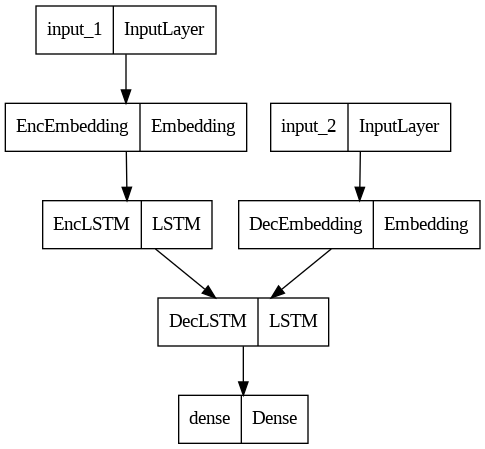

In [ ]:
plot_model(model)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [ ]:
history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=20,
                    validation_split=0.10,
                    validation_batch_size=32,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/20
2388/2391 [============================>.] - ETA: 0s - loss: 1.1108
Epoch 1: val_loss improved from inf to 0.55093, saving model to model.h5
2391/2391 [==============================] - 27s 11ms/step - loss: 1.1102 - val_loss: 0.5509
Epoch 2/20
  11/2391 [..............................] - ETA: 24s - loss: 0.5404

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2389/2391 [============================>.] - ETA: 0s - loss: 0.4600
Epoch 2: val_loss improved from 0.55093 to 0.40834, saving model to model.h5
2391/2391 [==============================] - 23s 10ms/step - loss: 0.4599 - val_loss: 0.4083
Epoch 3/20
2390/2391 [============================>.] - ETA: 0s - loss: 0.3524
Epoch 3: val_loss improved from 0.40834 to 0.35715, saving model to model.h5
2391/2391 [==============================] - 24s 10ms/step - loss: 0.3524 - val_loss: 0.3571
Epoch 4/20
2386/2391 [============================>.] - ETA: 0s - loss: 0.2970
Epoch 4: val_loss improved from 0.35715 to 0.33932, saving model to model.h5
2391/2391 [==============================] - 24s 10ms/step - loss: 0.2970 - val_loss: 0.3393
Epoch 5/20
2391/2391 [==============================] - ETA: 0s - loss: 0.2571
Epoch 5: val_loss improved from 0.33932 to 0.32663, saving model to model.h5
2391/2391 [==============================] - 25s 10ms/step - loss: 0.2571 - val_loss: 0.3266
Epoch 6/20
2388

In [ ]:
model.save('w2p.h5')

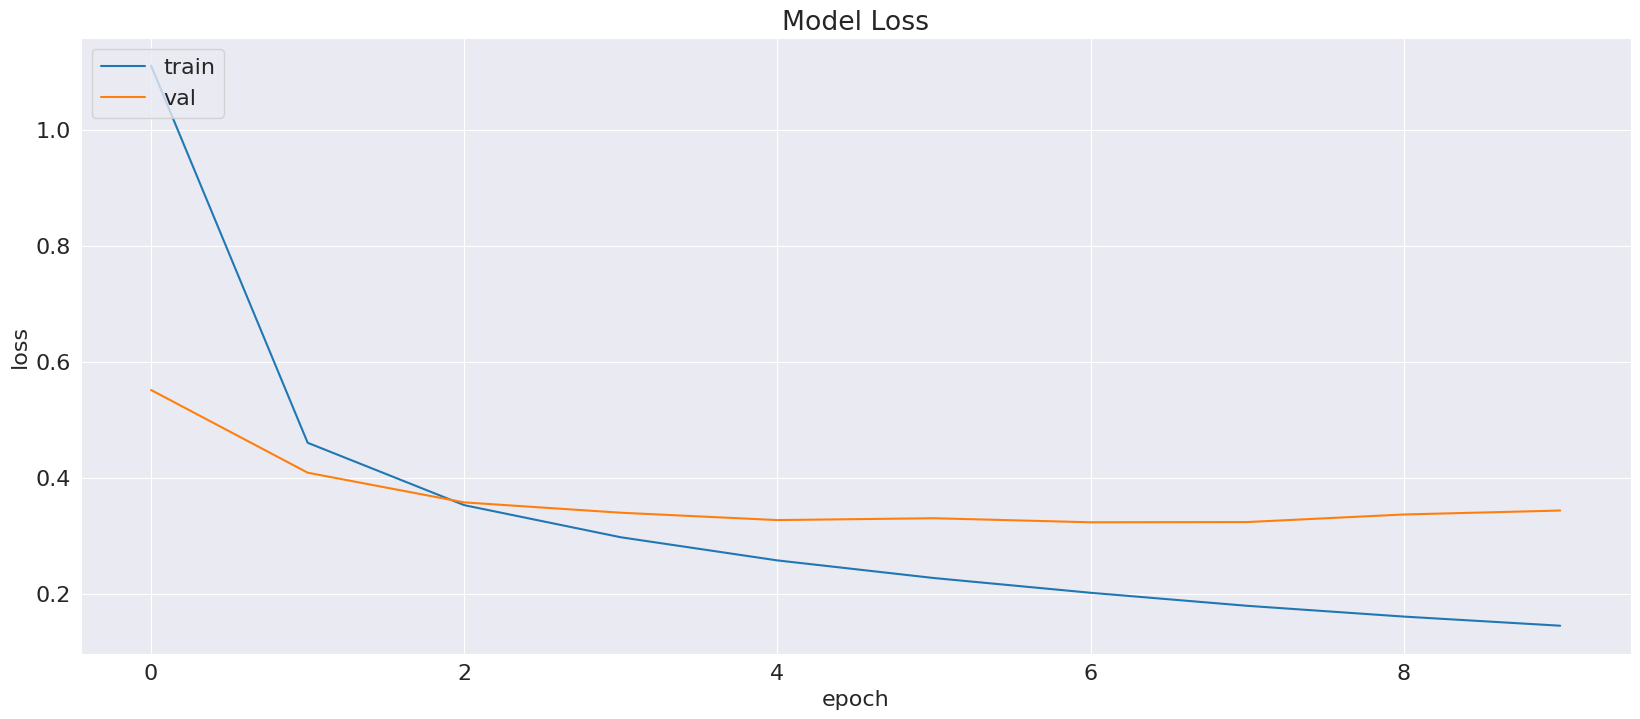

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
encoder = Model(char_input, [state_h, state_c])

#Decoder
decoder_input_h = Input(shape=(256,))
decoder_input_c = Input(shape=(256,))
x = embedding_layer(ph_input)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = softmax_dense(x)
decoder = Model([ph_input] + [decoder_input_h, decoder_input_c],
                                [x] + [decoder_output_h, decoder_output_c])

In [ ]:
def predict_pronunciation(ch_input):
    input_seq = char_tokenizer.texts_to_sequences([ch_input])

    next_h, next_c = encoder.predict(input_seq, verbose=0)

    curr_token = np.zeros((1, 1))
    curr_token[0, 0] = phone_tokenizer.word_index['startseq']

    pred_sentence = ''

    for i in range(max_len_op):
        output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c], verbose=0)
        next_token = np.argmax(output[0, 0, :])
        next_word = phone_tokenizer.index_word[next_token]
        if next_word == 'endseq':
            break
        else:
            pred_sentence += ' ' + next_word
            curr_token[0, 0] = next_token

    return pred_sentence

In [ ]:
words = ['helds','cardholder','siddhant','shardul','laughed','salamance','christopher',
         'avanish','garchomp','absol','gliscor','isha','sesquepedalian','crying',
         'backstabbing','harsh','avantika','strong','originate']

for word in words:
    phoneme = predict_pronunciation(word)
    print(f"Word: {word}, Phoneme: {phoneme}\n")


Word: helds, Phoneme:  hh eh1 l d z

Word: cardholder, Phoneme:  k aa1 r d hh ow2 l d er0

Word: siddhant, Phoneme:  s ih1 d ah0 n t

Word: shardul, Phoneme:  sh aa1 r d ah0 l

Word: laughed, Phoneme:  l aa1 f t

Word: salamance, Phoneme:  s ae1 l ah0 m ah0 n s

Word: christopher, Phoneme:  k r ih1 s ah0 th er0

Word: avanish, Phoneme:  ae1 v ah0 n ih0 sh

Word: garchomp, Phoneme:  g aa1 r ch ow2 m

Word: absol, Phoneme:  ae1 b s ah0 l

Word: gliscor, Phoneme:  g l ih1 s k er0

Word: isha, Phoneme:  ih1 sh ah0

Word: sesquepedalian, Phoneme:  s eh2 s k w ah0 p ah0 l ay1 n ah0

Word: crying, Phoneme:  k r ay1 ih0 ng

Word: backstabbing, Phoneme:  b ae1 k s t b ae2 b ih0 ng

Word: harsh, Phoneme:  hh aa1 r sh

Word: avantika, Phoneme:  aa0 v aa0 n t aa1 k ah0

Word: strong, Phoneme:  s t r aa1 ng

Word: originate, Phoneme:  er0 ih1 jh ah0 n ey2 t



# Speech To Phoneme

In [ ]:
dataset = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test", streaming = True)

In [ ]:
dataset_head = dataset.take(500)

In [ ]:
num_examples = 0
num_columns = None

for example in dataset_head:
    num_examples += 1
    if num_columns is None:
        num_columns = len(example.keys())

# Print the shape
print("Number of Examples:", num_examples)
print("Number of Columns:", num_columns)

Reading metadata...: 16354it [00:01, 12308.44it/s]


Number of Examples: 500
Number of Columns: 11


In [ ]:
feature_names = dataset_head.features.keys()
feature_names

dict_keys(['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'])

### Separating Audio and Sentence from the Dataset

In [ ]:
audio_data = []
sentence_data = []

# Iterate through the dataset and extract the 'audio' and 'sentence' columns
for example in dataset_head:
    if 'audio' in example and 'sentence' in example:
        audio_data.append(example['audio'])
        sentence_data.append(example['sentence'])

Reading metadata...: 16354it [00:00, 43750.47it/s]


### Predicting the `phonemes` for each sentence

In [ ]:
predicted_phonemes = []
# Iterate through the dataset and generate phoneme sequences for each sentence
for sentence in sentence_data:
    predicted_phoneme = predict_pronunciation(sentence)
    predicted_phonemes.append(predicted_phoneme)


### Mapping the column of `predicted_phonemes` to their sentences in the dataset

In [ ]:
name = "predicted_phonemes"

predicted_phonemes = ['startseq ' + s + ' endseq' for s in predicted_phonemes]

new_features = dataset_head.features.copy()
new_features[name] = new_features["sentence"]

def add_column_fn_1(example, idx):
    if name in example:
        raise ValueError(f"Error when adding {name}: column {name} is already in the dataset.")
    return {name: predicted_phonemes[idx]}

data = dataset_head.map(add_column_fn_1, with_indices=True, features=new_features)

In [ ]:
feature_names = data.features.keys()
feature_names

dict_keys(['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'predicted_phonemes'])

In [ ]:
# Convert the iterable dataset to a list of dictionaries
data_list = list(data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)

# Optionally, you can set the column names to the feature_names
df.columns = feature_names

Reading metadata...: 16354it [00:00, 42560.10it/s]


In [ ]:
# Separate the 'audio' column into three separate columns: 'path', 'array', and 'sr'
df['array'] = df['audio'].apply(lambda x: x['array'])
df['sr'] = df['audio'].apply(lambda x: x['sampling_rate'])

# Drop the original 'audio' column if you no longer need it
df = df.drop(columns=['audio'])

columns_to_keep = ['path', 'array', 'sr', 'sentence', 'predicted_phonemes']
df = df[columns_to_keep]


In [ ]:
df.head()

,path,array,sr,sentence,predicted_phonemes
0,en_test_0/common_voice_en_27710027.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,"Joe Keaton disapproved of films, and Buster al...",startseq jh ow2 ih0 k s ih2 n d ow2 g r ah0 t...
1,en_test_0/common_voice_en_699711.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,She'll be all right.,startseq sh iy2 l b ah0 l ih1 sh t r ih0 th e...
2,en_test_0/common_voice_en_21953345.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,six,startseq s ih1 k s endseq
3,en_test_0/common_voice_en_18132047.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,All's well that ends well.,startseq ae2 l ah0 s w ah0 l t eh1 s t ah0 l ...
4,en_test_0/common_voice_en_27340672.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,It is a busy market town that serves a large s...,startseq ih2 t iy0 k ah2 n d w ao2 r s ah0 th...


You can see that all the columns needed are there

In [ ]:
def create_mfcc_features(x, sr):
    mfccs = []
    try:
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs


In [ ]:
mfcc_features = {}

for index, row in df.iterrows():
    audio_data = row['array']
    audio_sr = row['sr']
    audio_path = row['path']

    try:
        mfcc_features[audio_path] = create_mfcc_features(audio_data, audio_sr)
    except Exception as e:
        print(f'Error processing audio file {audio_path}: {str(e)}')


In [ ]:
sentences = df['predicted_phonemes'].values


In [ ]:
sentences[:5]

array(['startseq  jh ow2 ih0 k s ih2 n d ow2 g r ah0 th ah0 s t ao2 g r ah0 m ah0 t ao1 l y ah0 t ah0 v endseq',
       'startseq  sh iy2 l b ah0 l ih1 sh t r ih0 th endseq',
       'startseq  s ih1 k s endseq',
       'startseq  ae2 l ah0 s w ah0 l t eh1 s t ah0 l ah0 n b ah0 l endseq',
       'startseq  ih2 t iy0 k ah2 n d w ao2 r s ah0 th l ah0 s t er2 ih0 g n eh1 r ah0 k ah0 p er0 endseq'],
      dtype=object)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in sentences)

In [ ]:
print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Sequence Length: {max_length}")

Vocabulary Size: 67
Maximum Sequence Length: 32


In [ ]:
def get_model_input(df):

    X_feature, X_seq, y = list(), list(), list()
    audio_files = df['path'].tolist()

    for audio_file in audio_files:
        # Extract MFCC features and reshape them
        feature = mfcc_features[audio_file].reshape(16, 8, 1)

        # Extract predicted phoneme sequences for the current audio file
        captions = df.loc[df['path'] == audio_file, 'predicted_phonemes'].tolist()

        # Iterate through the predicted phoneme sequences
        for caption in captions:
            # Convert the phoneme sequence to numerical tokens
            sequence = tokenizer.texts_to_sequences([caption])[0]

            # Iterate through the phoneme sequence tokens
            for i in range(1, len(sequence)):
                # Split the sequence into input and output segments
                in_sequence, out_sequence = sequence[:i], sequence[i]

                # Pad the input sequence to a consistent length
                in_sequence = tf.keras.preprocessing.sequence.pad_sequences([in_sequence], maxlen=max_length)[0]

                # Convert the output sequence to one-hot encoded format
                out_sequence = tf.keras.utils.to_categorical([out_sequence], num_classes=vocab_size)[0]

                # Append data to respective lists
                X_feature.append(feature)  # MFCC features
                X_seq.append(in_sequence)  # Input sequence
                y.append(out_sequence)     # Target output sequence

    # Convert lists to NumPy arrays for model training
    X_feature, X_seq, y = np.array(X_feature), np.array(X_seq), np.array(y)

    # Return the prepared data
    return X_feature, X_seq, y


In [ ]:
train, test = train_test_split(df, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.shape, test.shape

((400, 5), (100, 5))

In [ ]:
train_feature, train_seq, train_y = get_model_input(train)
test_feature, test_seq, test_y = get_model_input(test)

train_feature.shape, train_seq.shape, train_y.shape

((10271, 16, 8, 1), (10271, 32), (10271, 67))

In [ ]:
input_model_1 = Input(shape=(16, 8, 1)) #speech
feature_model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same")(input_model_1)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same")(feature_model)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Flatten()(feature_model)
feature_model = Dense(256, activation='relu')(feature_model)

# LSTM  model
input_model_2 = Input(shape=(max_length,)) #phonemes
seq_model = Embedding(vocab_size, 128, mask_zero=True)(input_model_2)
seq_model = Dropout(0.5)(seq_model)
seq_model = LSTM(256, activation='relu')(seq_model)

# Merging both models
decoder = add([feature_model, seq_model])
decoder = Dense(256, activation='relu')(decoder)
output_model = Dense(vocab_size, activation='softmax')(decoder)

# [image, seq] [word]
model = Model(inputs=[input_model_1, input_model_2], outputs=output_model)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))



In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16, 8, 1)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 8, 16)            160       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 4, 16)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 4, 8)              1160      ['max_pooling2d[0][0]'] 

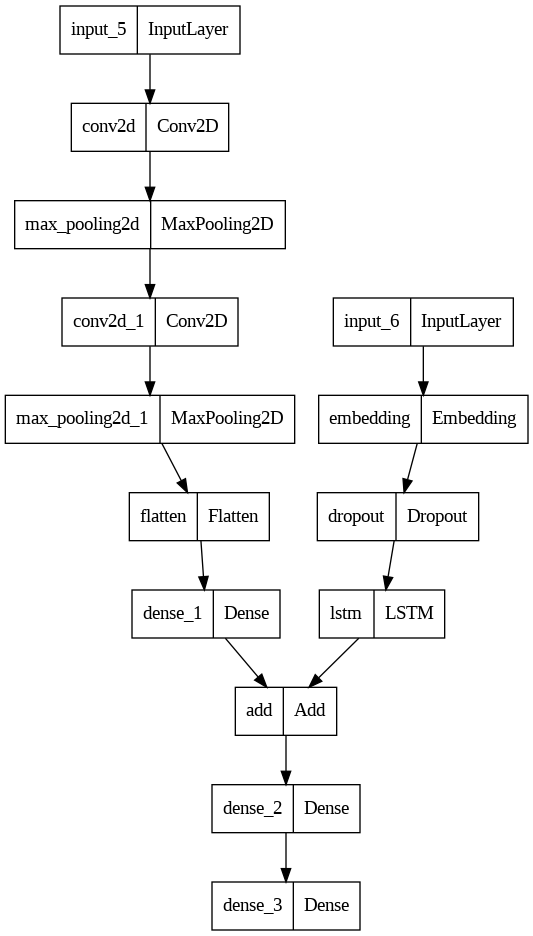

In [ ]:
plot_model(model)

In [ ]:
model_name = "phoneme_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00000001)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
history = model.fit((train_feature, train_seq), train_y, epochs=50,
                    validation_data=((test_feature, test_seq), test_y), callbacks=[checkpoint, earlystopping, reduce_lr])

Epoch 1/50
321/321 [==============================] - ETA: 0s - loss: 3.5114
Epoch 1: val_loss improved from inf to 3.31216, saving model to phoneme_model.h5
321/321 [==============================] - 29s 66ms/step - loss: 3.5114 - val_loss: 3.3122 - lr: 0.0010
Epoch 2/50
  2/321 [..............................] - ETA: 18s - loss: 3.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/321 [============================>.] - ETA: 0s - loss: 3.0950
Epoch 2: val_loss improved from 3.31216 to 2.86155, saving model to phoneme_model.h5
321/321 [==============================] - 19s 60ms/step - loss: 3.0944 - val_loss: 2.8616 - lr: 0.0010
Epoch 3/50
321/321 [==============================] - ETA: 0s - loss: 2.7982
Epoch 3: val_loss improved from 2.86155 to 2.68646, saving model to phoneme_model.h5
321/321 [==============================] - 19s 60ms/step - loss: 2.7982 - val_loss: 2.6865 - lr: 0.0010
Epoch 4/50
321/321 [==============================] - ETA: 0s - loss: 2.6533
Epoch 4: val_loss improved from 2.68646 to 2.59587, saving model to phoneme_model.h5
321/321 [==============================] - 19s 60ms/step - loss: 2.6533 - val_loss: 2.5959 - lr: 0.0010
Epoch 5/50
321/321 [==============================] - ETA: 0s - loss: 2.5536
Epoch 5: val_loss improved from 2.59587 to 2.54289, saving model to phoneme_model.h5
321/321 [==============================] - 19s 60ms

In [ ]:
model.save('s2p.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def inverse_tokenizer(index):
    for word, i in tokenizer.word_index.items(): #what is the index of our word in the dataset
        if i==index:
            return word
    return None

In [ ]:
def speech_to_text(audio_path):
    # path = audio_path.split('/')[-1]
    feature = mfcc_features[audio_path].reshape(-1, 16, 8, 1) #make mfcc and reshape
    pred_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([pred_text])[0]#converting text to sequence
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence]) #prediction
        y_pred = np.argmax(y_pred)
        word = inverse_tokenizer(y_pred)
        if word is None:
            break
        pred_text+= " " + word
        if word == 'endseq':
            break
    return pred_text

In [ ]:
sample_df = test.sample(1)
files = sample_df['path'].tolist()
actual_transcription = sample_df['predicted_phonemes'].tolist()
pred_transcription = []
for file in files:
    transcription = speech_to_text(file)
    pred_transcription.append(transcription)

1/1 [==============================] - 0s 23ms/step


In [ ]:
sample_df['sentence']

38    The girl dropped the container, and the water ...
Name: sentence, dtype: object

In [ ]:
pred_transcription

['startseq th eh2 r ah0 n s t ih2 n s t ah0 l t ah0 s t ah0 l ah0 n t eh1 sh ah0 n ah0 l ah0 n t endseq']

# Phoneme To Word

In [ ]:
words = []
phonics_list = []
dict_file = open('/content/cmudict.dict', 'r')
with dict_file as f:
    phonics = [line.rstrip('\n') for line in f]
    for p in phonics:
        x = p.split(' ')
        words.append(x[0])
        phonics_list.append(' '.join(x[1:]))
ptw = pd.DataFrame({'Word': words, 'Phonics': phonics_list})
ptw.head()

,Word,Phonics
0,'bout,B AW1 T
1,'cause,K AH0 Z
2,'course,K AO1 R S
3,'cuse,K Y UW1 Z
4,'em,AH0 M


In [ ]:
ptw = ptw.sample(100000).reset_index(drop=True)
ptw

,Word,Phonics
0,schwarzkopf's(2),SH W AO1 R T S K AO0 F S
1,dissipate,D IH1 S AH0 P EY2 T
2,projective,P R AH0 JH EH1 K T IH0 V
3,sossamon,S OW0 S AA0 M AO1 N
4,ciszek,CH IH1 SH EH0 K
...,...,...
99995,seagren,S IY1 G R EH0 N
99996,beaucoup,B OW2 K UW1
99997,zaitsev,Z EY1 T S EH0 V
99998,quakenbush,K W AH0 K EH1 N B UH0 SH


In [ ]:
ptw[~ptw['Word'].apply(lambda x: x.isalnum())]

,Word,Phonics
0,schwarzkopf's(2),SH W AO1 R T S K AO0 F S
8,ailurophile(2),EY0 L UH1 R AH0 F AY0 AH0 L
16,ratepayers',R EY1 T P EY2 ER0 Z
18,expresso(2),EH0 K S P EH1 S OW0
22,ions(2),AY1 AA2 N Z
...,...,...
99962,episcopalians(2),IH0 P IH2 S K AH0 P EY1 L Y AH0 N Z
99970,l'enfant(2),L AA2 N F AA1 N T
99978,for(3),F R ER0
99990,jean-louis,ZH AA2 N L UW0 IY1


In [ ]:
ptw['Word'] = 'startseq ' + ptw['Word']+ ' endseq'
ptw.head()

,Word,Phonics
0,startseq schwarzkopf's(2) endseq,SH W AO1 R T S K AO0 F S
1,startseq dissipate endseq,D IH1 S AH0 P EY2 T
2,startseq projective endseq,P R AH0 JH EH1 K T IH0 V
3,startseq sossamon endseq,S OW0 S AA0 M AO1 N
4,startseq ciszek endseq,CH IH1 SH EH0 K


In [ ]:
max_len_op = ptw['Word'].apply(lambda x: len(x)).max()
max_len_ip = ptw['Phonics'].apply(lambda x: len(x.split())).max()

In [ ]:
words = ptw['Word'].tolist()
phonemes = ptw['Phonics'].tolist()

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(words)
word_vocab_size = len(word_tokenizer.word_index) + 1
print("Word Vocab Size: ",word_vocab_size)

Word Vocab Size:  94311


In [ ]:
phone_tokenizer = Tokenizer(oov_token='OOV')
phone_tokenizer.fit_on_texts(phonemes)
phone_vocab_size = len(phone_tokenizer.word_index) + 1
print("Phoneme Vocab Size: ",phone_vocab_size)

Phoneme Vocab Size:  76


In [ ]:
wd_sequences = word_tokenizer.texts_to_sequences(words)
ph_sequences = phone_tokenizer.texts_to_sequences(phonemes)

In [ ]:
print("Word: ", words[3])
print("Word Sequence: ",wd_sequences[3])

Word:  startseq sossamon endseq
Word Sequence:  [1, 5481, 2]


In [ ]:
encoder_inputs = pad_sequences(ph_sequences, maxlen=max_len_ip, padding='post')

In [ ]:
decoder_inputs = []
decoder_outputs = []

In [ ]:
for wd in wd_sequences:
    decoder_inputs.append(wd[:-1])
    decoder_outputs.append(wd[1:])

In [ ]:
decoder_inputs = pad_sequences(decoder_inputs, maxlen=max_len_op, padding='post')
decoder_outputs = pad_sequences(decoder_outputs, maxlen=max_len_op, padding='post')

In [ ]:
n = len(phonemes)
split_index = int(0.85 * n)

In [ ]:
X_train = [encoder_inputs[:split_index], decoder_inputs[:split_index]]
y_train = decoder_outputs[:split_index]

In [ ]:
X_test = phonemes[split_index:]
y_test = words[split_index:]

In [ ]:
ph_vocab = 76

In [ ]:
# Encoder
ph_input = Input(shape=(None,))
x = Embedding(ph_vocab, 256, mask_zero=True)(ph_input)
output_y, state_h, state_c = LSTM(256, return_state=True)(x)

In [ ]:
# Decoder
wd_input = Input(shape=(None,))
embedding_layer = Embedding(word_vocab_size, 256, mask_zero=True)
x = embedding_layer(wd_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
output_y, _ , _ = decoder_lstm(x, initial_state=[state_h, state_c])
intermediate_dense = Dense(256, activation='relu')(output_y)
softmax_dense = Dense(word_vocab_size, activation='softmax')
output = softmax_dense(intermediate_dense)

In [ ]:
model = Model(inputs=[ph_input, wd_input],outputs=output)
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            19456     ['input_7[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, None, 256)            2414361   ['input_8[0][0]']             
                                                          6                                 

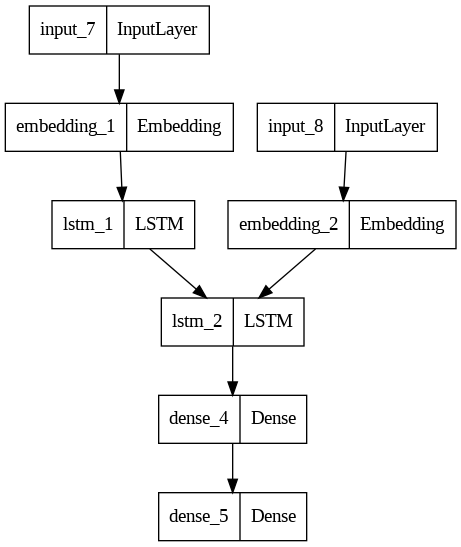

In [ ]:
plot_model(model)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [ ]:
history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.10,
                    validation_batch_size=32,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/10
2391/2391 [==============================] - ETA: 0s - loss: 5.8664
Epoch 1: val_loss improved from inf to 5.94859, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2391/2391 [==============================] - 255s 103ms/step - loss: 5.8664 - val_loss: 5.9486
Epoch 2/10
2391/2391 [==============================] - ETA: 0s - loss: 5.6116
Epoch 2: val_loss did not improve from 5.94859
2391/2391 [==============================] - 241s 101ms/step - loss: 5.6116 - val_loss: 6.5236
Epoch 3/10
2391/2391 [==============================] - ETA: 0s - loss: 5.4378
Epoch 3: val_loss did not improve from 5.94859
2391/2391 [==============================] - 240s 101ms/step - loss: 5.4378 - val_loss: 6.8092
Epoch 4/10
2391/2391 [==============================] - ETA: 0s - loss: 5.0975
Epoch 4: val_loss did not improve from 5.94859
Restoring model weights from the end of the best epoch: 1.
2391/2391 [==============================] - 241s 101ms/step - loss: 5.0975 - val_loss: 7.5934
Epoch 4: early stopping


In [ ]:
model.save('p2w.h5')

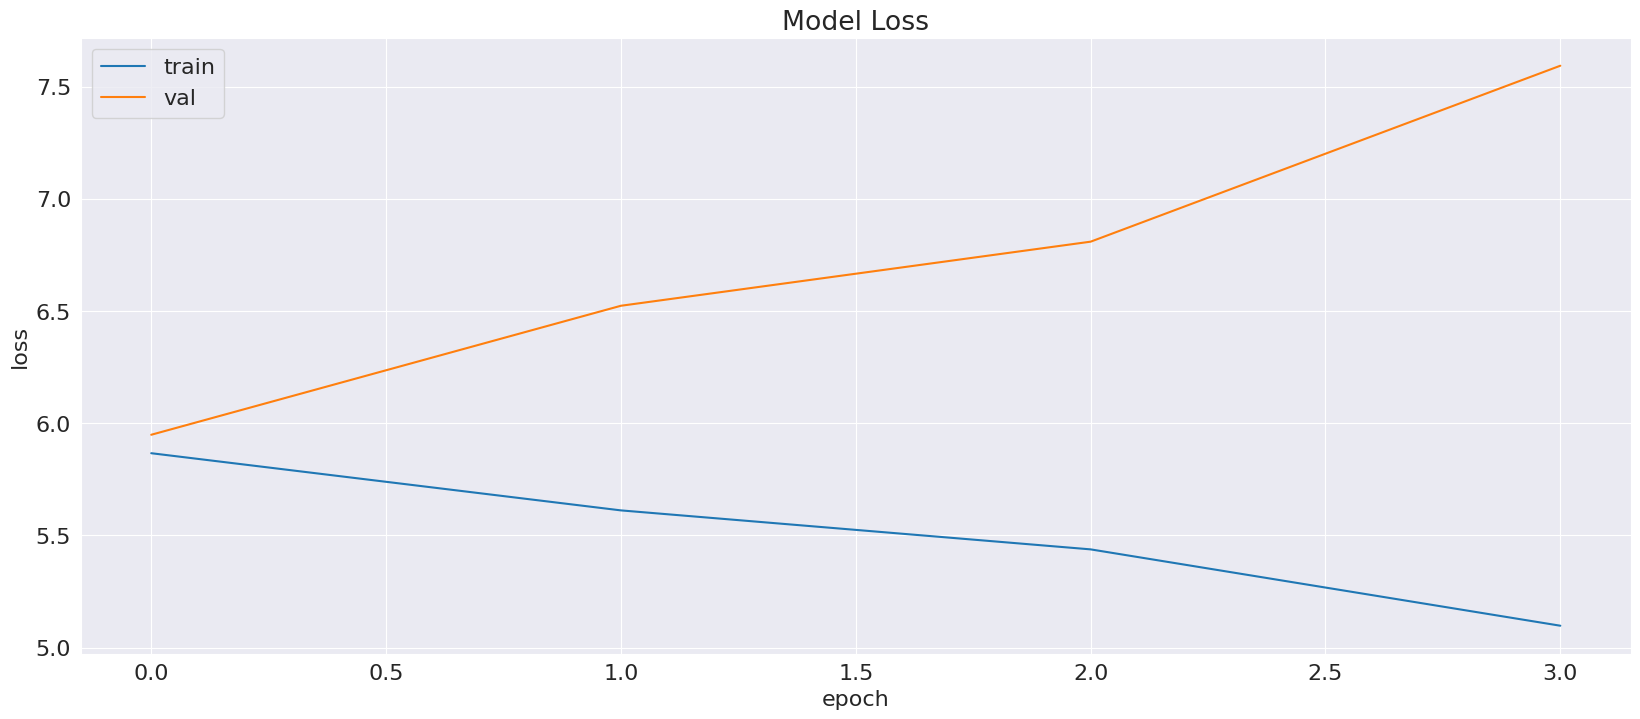

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
encoder = Model(ph_input, [state_h, state_c])

#Decoder
wd_input = Input(shape=(None,))
decoder_input_h = Input(shape=(256,))
decoder_input_c = Input(shape=(256,))
x = embedding_layer(wd_input)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = softmax_dense(x)
decoder = Model([wd_input] + [decoder_input_h, decoder_input_c],
                                [x] + [decoder_output_h, decoder_output_c])
decoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 256)            2414361   ['input_9[0][0]']             
                                                          6                                       
                                                                                                  
 input_10 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 256)]                0         []                      

In [ ]:
def predict_word(wd_input):
    input_seq = phone_tokenizer.texts_to_sequences([wd_input])

    next_h, next_c = encoder.predict(input_seq, verbose=0)
    curr_token = np.zeros((1, 1))
    curr_token[0, 0] = word_tokenizer.word_index['startseq']

    pred_sentence = ''

    for i in range(max_len_op):
        output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c], verbose=0)
        next_token = np.argmax(output[0, 0, :])
        next_word = word_tokenizer.index_word[next_token]
        if next_word == 'endseq':
            break
        else:
          pred_sentence += ' ' + next_word
          curr_token[0, 0] = next_token

    return pred_sentence

In [ ]:
for sentence in pred_transcription:
    phoneme = predict_word(sentence)
    print(f"Phoneme: {sentence} \n Sentence: {phoneme}\n")


Phoneme: startseq th eh2 r ah0 n s t ih2 n s t ah0 l t ah0 s t ah0 l ah0 n t eh1 sh ah0 n ah0 l ah0 n t endseq 
 Sentence:  men dilutes leno's surprise surprise economically leno's surprise economically self middle middle sufficiency sufficiency economically non sufficiency sufficiency sufficiency economically non sufficiency sufficiency sufficiency sufficiency economically non sufficiency sufficiency sufficiency sufficiency economically non sufficiency sufficiency sufficiency sufficiency economically non sufficiency sufficiency sufficiency sufficiency economically



this is a niche and developing field where advancements are still being made as models are not able to capture the semantics